In [1]:
import os
import pathlib
import random
import functools
import copy
import sys
import pickle
import tarfile
import operator
import math
import requests
import importlib

import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn import preprocessing
import scipy

import tensorflow as tf
import tensorflow_datasets as tfds

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import flax

import neural_tangents as nt

import vit_jax

import adversarial_ntks as atk

In [2]:
SAMPLES = 10
SAMPLE_IMG_SIZE = 3

In [3]:
CIFAR10 = {
    "train": atk.dataset.get_np_data(
        name="cifar10", split="train", flatten=False, data_dir=".data/"),
    "test": atk.dataset.get_np_data(
        name="cifar10", split="test[:2000]", flatten=False, data_dir=".data/"),
    "channels": 3,
    "labels": ["airplane", "automobile", "bird", "cat", "deer",
        "dog", "frog", "horse", "ship", "truck"],
    
    "batch_size": 200,
    "pretrained_model": "ViT-B_16",
    
    "total_steps": 1000,
    "warmup_steps": 5,
    "decay_type": "cosine",
    "grad_norm_clip": 1,
    
    "accum_steps": 20,
    "base_lr": 0.05,
    
    "perturb_target": 3,
    "perturb_eps": 0.02,
    "perturb_eps_norm": np.inf,
    "perturb_num_steps": 15,
    "perturb_step_size": 0.003,
    "perturb_step_norm": np.inf
}

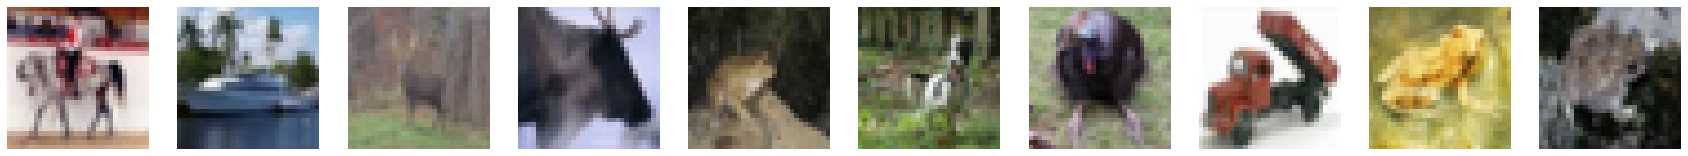

Labels:  ['horse', 'ship', 'deer', 'deer', 'frog', 'dog', 'bird', 'truck', 'frog', 'frog']


In [4]:
def exp_show(exp):
    exp.update({
        "num_classes": len(exp["labels"])
    })
    plt.figure(figsize=(SAMPLES * SAMPLE_IMG_SIZE, SAMPLE_IMG_SIZE))
    atk.dataset.plot_sample_data(exp["train"][0][:SAMPLES], flat=False, channels=exp["channels"])
    print("Labels: ", [exp["labels"][a]
        for a in exp["train"][1][:SAMPLES]])
    
exp_show(CIFAR10)

In [5]:
def exp_get_accuracy(exp, params_repl, test_imgs, test_labels):
    good = total = 0
    for step in tqdm.tqdm(range(len(test_imgs) // exp["batch_size"])):
        # Get the next batch.
        batch = test_imgs[step * exp["batch_size"]:(step + 1) * exp["batch_size"]]
        batch_labels = test_labels[step * exp["batch_size"]:(step + 1) * exp["batch_size"]]
        predictions = exp["vit_apply_repl"](
            params_repl, np.array([batch]))

        # Predictions are likely constant on the pretrained initialization.
        is_same = predictions.argmax(axis=-1) == np.array([batch_labels])
        good += is_same.sum()
        total += len(is_same.flatten())
    return good / total

def exp_show_accuracy(exp, params_repl, test_imgs, test_labels):
    batch = test_imgs[:exp["batch_size"]]
    batch_labels = test_labels[:exp["batch_size"]]
    batch_predictions = exp["vit_apply_repl"](params_repl, np.array([batch]))
    print("Correct labels:", [exp["labels"][a]
        for a in batch_labels[:SAMPLES]])
    plt.figure(figsize=(SAMPLES * SAMPLE_IMG_SIZE, SAMPLE_IMG_SIZE))
    atk.dataset.plot_sample_data(batch[:SAMPLES], flat=False, channels=exp["channels"])
    print("Predicted labels:", [exp["labels"][a]
        for a in batch_predictions[0][:SAMPLES].argmax(axis=-1)])
    
def exp_show_rob_accuracy(exp, params_repl, test_imgs, test_labels, test_perturbed):
    exp_show_accuracy(exp, params_repl, test_imgs, test_labels)
    perturbed_batch = test_perturbed[:exp["batch_size"]]
    perturbed_predictions = exp["vit_apply_repl"](
        params_repl, np.array([perturbed_batch]))
    plt.figure(figsize=(SAMPLES * SAMPLE_IMG_SIZE, SAMPLE_IMG_SIZE))
    atk.dataset.plot_sample_data(perturbed_batch[:SAMPLES], flat=False, channels=exp["channels"])
    print("Perturbed labels:", [exp["labels"][a]
        for a in perturbed_predictions[0][:SAMPLES].argmax(axis=-1)])

2021-01-27 05:20:47,091 [WARNING] vit_jax.logging: Inspect recovered empty keys:
{'pre_logits'}
2021-01-27 05:20:47,093 [INFO] vit_jax.logging: Inspect extra keys:
{'pre_logits/bias', 'pre_logits/kernel'}
2021-01-27 05:20:47,094 [INFO] vit_jax.logging: load_pretrained: drop-head variant
2021-01-27 05:20:47,095 [INFO] vit_jax.logging: load_pretrained: resized variant: (1, 197, 768) to (1, 5, 768)
2021-01-27 05:20:47,096 [INFO] vit_jax.logging: load_pretrained: grid-size from 14 to 2
100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Correct labels: ['horse', 'airplane', 'frog', 'truck', 'dog', 'automobile', 'horse', 'airplane', 'cat', 'bird']


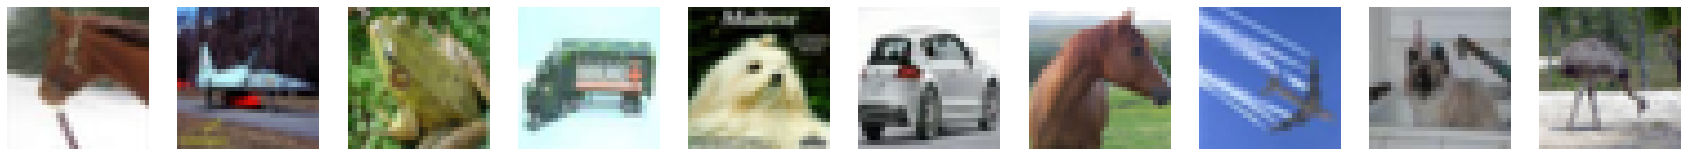

Predicted labels: ['airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane']
CIFAR10 accuracies: {'test_pretrained': 0.113}


In [6]:
def exp_test_pretrained(exp):
    exp.update({
    "model": vit_jax.models.KNOWN_MODELS[exp["pretrained_model"]] \
        .partial(num_classes=exp["num_classes"])
    })
    exp.update({
        "params": vit_jax.checkpoint.load_pretrained(
            pretrained_path=".models/" + exp["pretrained_model"] + ".npz",
            init_params=exp["model"].init_by_shape(
                jax.random.PRNGKey(0),
                [((exp["batch_size"], *exp["train"][0][0].shape), "float32")])[1],
            model_config=vit_jax.models.CONFIGS[exp["pretrained_model"]],
            logger=vit_jax.logging.setup_logger('.logs/'))
    })
    exp.update({
        "params_repl": flax.jax_utils.replicate(exp["params"]),
        "vit_apply_repl": jax.pmap(exp["model"].call)
    })
    exp.update({
        "accuracies": {
            "test_pretrained": float(exp_get_accuracy(
                exp, exp["params_repl"], *exp["test"]))
        }
    })
    
exp_test_pretrained(CIFAR10)
exp_show_accuracy(CIFAR10, CIFAR10["params_repl"], *CIFAR10["test"])
print("CIFAR10 accuracies:", CIFAR10["accuracies"])  # Should be about 0.1.

100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


Correct labels: ['horse', 'airplane', 'frog', 'truck', 'dog', 'automobile', 'horse', 'airplane', 'cat', 'bird']


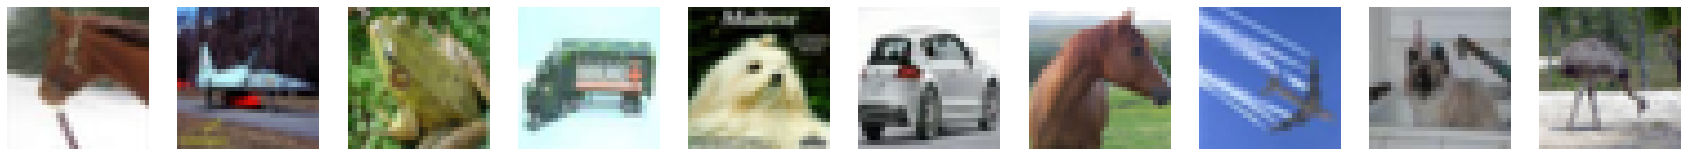

Predicted labels: ['horse', 'airplane', 'frog', 'truck', 'dog', 'automobile', 'horse', 'airplane', 'cat', 'horse']
CIFAR10 accuracies: {'test_pretrained': 0.113, 'test_fine_tuned': 0.7865}


In [7]:
def exp_fine_tune(exp):
    # Fine-tune the final layer
    exp.update({
        "update_fn_repl": vit_jax.train.make_update_fn(
            exp["model"].call, exp["accum_steps"]),
        "opt": vit_jax.momentum_clip.Optimizer(grad_norm_clip=exp["grad_norm_clip"]) \
            .create(exp["params"])
    })
    exp.update({
        "opt_repl": flax.jax_utils.replicate(exp["opt"]),
        "lr_fn": vit_jax.hyper.create_learning_rate_schedule(
            exp["total_steps"], exp["base_lr"],
            exp["decay_type"], exp["warmup_steps"])
    })
    exp.update({
        "lr_iter": vit_jax.hyper.lr_prefetch_iter(exp["lr_fn"], 0, exp["total_steps"]),
        "update_rngs": jax.random.split(jax.random.PRNGKey(0), jax.local_device_count())
    })

    for step, lr_repl in zip(
        tqdm.tqdm(range(exp["total_steps"])),
        exp["lr_iter"]):
        step_mod = step % (len(exp["train"][0]) // exp["batch_size"])
        batch = exp["train"][0][step_mod * exp["batch_size"]:(step_mod + 1) * exp["batch_size"]]
        batch_labels = exp["train"][1][step_mod * exp["batch_size"]:(step_mod + 1) * exp["batch_size"]]
        exp["opt_repl"], _, exp["update_rngs"] = exp["update_fn_repl"](
            exp["opt_repl"], lr_repl, {
                "image": np.array([batch]),
                "label": np.array([
                    [[1 if a == label else 0
                        for a in range(exp["num_classes"])]
                        for label in batch_labels]
                ])
            }, exp["update_rngs"])
    exp.update({
        "opt_repl_target": exp["opt_repl"].target
    })
    exp["accuracies"].update({
        "test_fine_tuned": float(exp_get_accuracy(
            exp, exp["opt_repl_target"], *exp["test"]))
    })
    
exp_fine_tune(CIFAR10)
exp_show_accuracy(CIFAR10, CIFAR10["opt_repl_target"], *CIFAR10["test"])
print("CIFAR10 accuracies:", CIFAR10["accuracies"])  # Should be over 0.9.

100%|██████████| 10/10 [00:00<00:00, 14.88it/s]


Correct labels: ['horse', 'airplane', 'frog', 'truck', 'dog', 'automobile', 'horse', 'airplane', 'cat', 'bird']


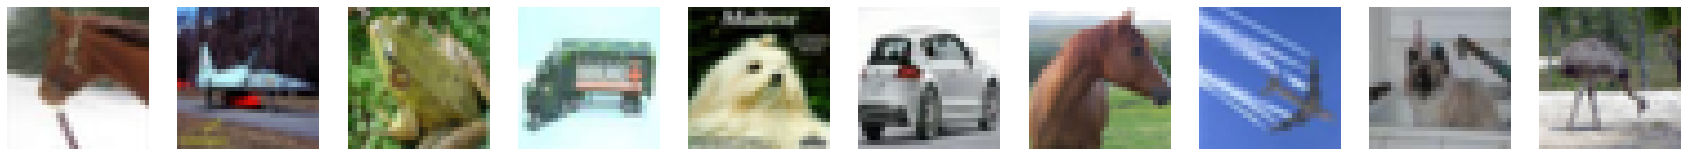

Predicted labels: ['horse', 'airplane', 'frog', 'truck', 'dog', 'automobile', 'horse', 'airplane', 'cat', 'horse']


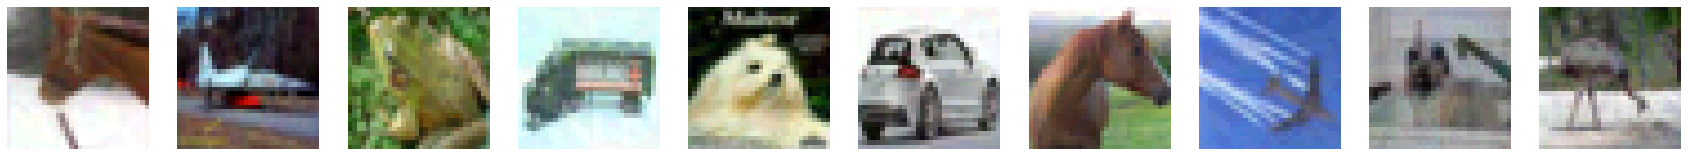

Perturbed labels: ['cat', 'cat', 'cat', 'cat', 'dog', 'automobile', 'cat', 'airplane', 'airplane', 'deer']
CIFAR10 accuracies: {'test_pretrained': 0.113, 'test_fine_tuned': 0.7865, 'test_perturbed': 0.287}


In [8]:
def exp_pgd(exp):
    exp["perturbed"] = []
    for step in tqdm.tqdm(range(len(exp["test"][0]) // exp["batch_size"])):
        # Get the next batch.
        batch = exp["test"][0][step * exp["batch_size"]:(step + 1) * exp["batch_size"]]
        batch_labels = exp["test"][1][step * exp["batch_size"]:(step + 1) * exp["batch_size"]]
        perturbed_batch = atk.attacks.pgd(
            batch.reshape((exp["batch_size"], -1)),
            batch_labels == exp["perturb_target"],  # Binary w.r.t. airplanes.
            lambda X: jnp.sum(jnp.array([
                jax.grad(lambda XX: exp["vit_apply_repl"](
                    exp["opt_repl_target"],
                    jnp.array([XX.reshape(batch.shape)]))[0][a][exp["perturb_target"]]
                )(X) for a in range(exp["batch_size"])]), axis=0),
            exp["perturb_eps"], exp["perturb_eps_norm"], exp["perturb_num_steps"],
            exp["perturb_step_size"], exp["perturb_step_norm"]).reshape(batch.shape)
        exp["perturbed"].append(perturbed_batch)
    exp["perturbed"] = np.vstack(exp["perturbed"])

    exp["accuracies"].update({
        "test_perturbed": float(exp_get_accuracy(
            exp, exp["opt_repl_target"],
            exp["perturbed"], exp["test"][1]))
    })
    
exp_pgd(CIFAR10)
exp_show_rob_accuracy(CIFAR10,
    CIFAR10["opt_repl_target"], *CIFAR10["test"], CIFAR10["perturbed"])
print("CIFAR10 accuracies:", CIFAR10["accuracies"])

In [9]:
print(CIFAR10["perturbed"].shape)
with open(".data/vit-pgd-cifar10.perturbed", "wb") as file:
    pickle.dump(CIFAR10["perturbed"], file)

(2000, 32, 32, 3)
